In [6]:
import csv
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MinuteLocator, DateFormatter


In [7]:
def Aanderaa_O2_compensation(meas_o2, temp, pres, sal, ref_sal=0):
    # Equations & coefficients from Aanderaa TD 269 Operating Manual for 4831, June 2017
    # https://www.aanderaa.com/media/pdfs/oxygen-optode-4330-4835-and-4831.pdf
    
    # Salinity
    B0 = -6.24097e-3
    B1 = -6.93498e-3
    B2 = -6.90358e-3
    B3 = -4.29155e-3
    C0 = -3.11680e-7

    ts = np.log((298.15-temp)/(273.15+temp))

    if ref_sal == 0:
        sal_corr_o2 = meas_o2 * np.exp(sal*(B0 + B1*ts + B2*ts**2 + B3*ts**3) + C0*sal**2)
    else:
        sal_corr_o2 = meas_o2 * np.exp((sal-ref_sal)*(B0 + B1*ts + B2*ts**2 + B3*ts**3) + C0*(sal**2 - ref_sal**2))

    # Apply pressure compensation to salinity-compensated values
    corr_o2 = sal_corr_o2 * (1 + (0.032*pres)/1000)

    return corr_o2


In [8]:
def calibrate_o2(data, m=1.15, b=-17):
    return (data/m)-b

In [9]:
def parse_ctd1_csv(cast_fpath, pres_thresh=0.5):
    datetimes = []
    pres = []
    temps = []
    sals = []
    oxys = []
    cal_oxys = []
    turbs = []
    dens = []

    cast_datestr = ''
    cast_timestr = ''
    cast_datetime = None
    date_idx = None
    time_idx = None
    pres_idx = None
    temp_idx = None
    sal_idx = None
    oxy_idx = None

    with open(cast_fpath, newline='') as f:
        reader = csv.reader(f)

        read_headings = False
        data_start = False
        data_row_idx = 0
        curr_hour = None
        last_min = None
        
        for row in reader:
            if not data_start and not read_headings:
                if row[0] == '[data]':
                    # Next row will contain header
                    read_headings = True
                elif row[0].split('=')[0] == 'date':
                    cast_datestr = row[0].split('=')[1]  # yyyy-mm-dd
                elif row[0].split('=')[0] == 'time':
                    cast_timestr = row[0].split('=')[1]  # HH:MM:SS.ms
                    
            elif read_headings:
                cast_datetime_str = cast_datestr + ':' + cast_timestr[:-3]  # ignore deci-second
                cast_datetime = dt.datetime.strptime(cast_datetime_str, '%Y-%m-%d:%H:%M:%S')
                curr_hour = cast_datetime.hour
                last_min = cast_datetime.minute

                date_idx = row.index('Date (yyyy-mm-dd)')
                turb_idx = row.index('Turbidity (NTU)')
                time_idx = row.index('Time')
                pres_idx = row.index('Pressure (dBar)')
                temp_idx = row.index('Temperature (C)')
                sal_idx = row.index('Salinity (PSU)')
                oxy_idx = row.index('Aanderaa 4831')
                dens_idx = row.index('Density (kg m-3)')
                read_headings = False
                # Now expect only data rows 
                data_start = True
            
            elif data_start:
                # Merge date & time into datetime object
                sample_date = dt.datetime.strptime(row[date_idx], '%Y-%m-%d')
                sample_time = row[time_idx]
                sample_min = int(sample_time.split(':')[0])
                sample_sec = int(sample_time.split(':')[1].split('.')[0])
                sample_dsec = sample_time.split(':')[1].split('.')[1]

                # Check for new hour
                if sample_min < last_min:
                    curr_hour += 1

                    # Check for new day
                    if curr_hour > 23:
                        curr_hour = 0

                last_min = sample_min

                sample_dt = sample_date.replace(
                    hour=curr_hour,
                    minute=sample_min,
                    second=sample_sec,
                    microsecond=int(sample_dsec) * int(1e5))

                # secs_since_start = 20 * data_row_idx
                # data_row_idx += 1
                # sample_dt = cast_datetime + dt.timedelta(seconds=secs_since_start)

                datetimes.append(sample_dt)
                p = float(row[pres_idx])
                temp = float(row[temp_idx])
                sal = float(row[sal_idx])
                oxy = float(row[oxy_idx])
                turb = float(row[turb_idx])
                den = float(row[dens_idx])

                pres.append(p)
                temps.append(temp)
                sals.append(sal)
                oxys.append(oxy)
                turbs.append(turb)
                dens.append(den)

                corr_o2 = Aanderaa_O2_compensation(oxy, temp, p, sal, ref_sal=0)
                cal_o2 = calibrate_o2(corr_o2)
                cal_oxys.append(corr_o2)
                
                
    return {
        'dts': datetimes,
        'pres': pres,
        'temps': temps,
        'sals': sals,
        'oxys': oxys,
        'cal_oxys': cal_oxys,
        'dens': dens,
        'turbs': turbs
    }

In [10]:
def parse_ctd2_csv(cast_fpath, pres_thresh=0.5):
    datetimes = []
    pres = []
    oxys = []
    turbs = []

    cast_datestr = ''
    cast_timestr = ''
    cast_datetime = None
    date_idx = None
    time_idx = None
    pres_idx = None
    sal_idx = None
    oxy_idx = None

    with open(cast_fpath, newline='') as f:
        reader = csv.reader(f)

        read_headings = False
        data_start = False
        data_row_idx = 0
        curr_hour = None
        last_min = None
        
        for row in reader:
            if not data_start and not read_headings:
                if row[0] == '[data]':
                    # Next row will contain header
                    read_headings = True
                elif row[0].split('=')[0] == 'date':
                    cast_datestr = row[0].split('=')[1]  # yyyy-mm-dd
                elif row[0].split('=')[0] == 'time':
                    cast_timestr = row[0].split('=')[1]  # HH:MM:SS.ms
                    
            elif read_headings:
                cast_datetime_str = cast_datestr + ':' + cast_timestr[:-3]  # ignore deci-second
                cast_datetime = dt.datetime.strptime(cast_datetime_str, '%Y-%m-%d:%H:%M:%S')
                curr_hour = cast_datetime.hour
                last_min = cast_datetime.minute

                date_idx = row.index('Date (yyyy-mm-dd)')
                turb_idx = row.index('Turbidity (NTU)')
                time_idx = row.index('Time')
                pres_idx = row.index('Pressure (dBar)')
                oxy_idx = row.index('Aanderaa 4831')
                read_headings = False
                # Now expect only data rows 
                data_start = True
            
            elif data_start:
                # Merge date & time into datetime object
                sample_date = dt.datetime.strptime(row[date_idx], '%Y-%m-%d')
                sample_time = row[time_idx]
                sample_min = int(sample_time.split(':')[0])
                sample_sec = int(sample_time.split(':')[1].split('.')[0])
                sample_dsec = sample_time.split(':')[1].split('.')[1]

                # Check for new hour
                if sample_min < last_min:
                    curr_hour += 1

                    # Check for new day
                    if curr_hour > 23:
                        curr_hour = 0

                last_min = sample_min

                sample_dt = sample_date.replace(
                    hour=curr_hour,
                    minute=sample_min,
                    second=sample_sec,
                    microsecond=int(sample_dsec) * int(1e5))

                # secs_since_start = 20 * data_row_idx
                # data_row_idx += 1
                # sample_dt = cast_datetime + dt.timedelta(seconds=secs_since_start)

                datetimes.append(sample_dt)
                p = float(row[pres_idx])
                oxy = float(row[oxy_idx])
                turb = float(row[turb_idx])

                pres.append(p)
                oxys.append(oxy)
                turbs.append(turb)                
                
    return {
        'dts': datetimes,
        'pres': pres,
        'oxys': oxys,
        'turbs': turbs
    }

In [11]:
ctd_file1 = 'AML/mooring_ctd1.csv'
ctd_file2 = 'AML/mooring_ctd2.csv'

ctd1 = parse_ctd1_csv(ctd_file1, pres_thresh=0.5)
ctd2 = parse_ctd2_csv(ctd_file2, pres_thresh=0.5)

Load tide data

In [24]:
tides_fp = '../Tides/Mooring.csv'
tides_ts = []
tides_level = []

with open(tides_fp, newline='') as f:
    reader = csv.reader(f, delimiter=';')
    for i, row in enumerate(reader):
        if i == 0: continue
        ts, pres = (row[0], row[1])
        tides_ts.append(dt.datetime.strptime(ts, '%Y-%m-%d %H:%M:%S'))
        tides_level.append(float(pres))

print(tides_ts)
print(tides_level)

[datetime.datetime(2023, 1, 15, 20, 50), datetime.datetime(2023, 1, 15, 21, 10), datetime.datetime(2023, 1, 15, 21, 30), datetime.datetime(2023, 1, 15, 21, 50), datetime.datetime(2023, 1, 15, 22, 50), datetime.datetime(2023, 1, 15, 23, 10), datetime.datetime(2023, 1, 15, 23, 30), datetime.datetime(2023, 1, 15, 23, 50), datetime.datetime(2023, 1, 16, 0, 10), datetime.datetime(2023, 1, 16, 0, 30), datetime.datetime(2023, 1, 16, 0, 50), datetime.datetime(2023, 1, 16, 1, 10), datetime.datetime(2023, 1, 16, 1, 30), datetime.datetime(2023, 1, 16, 1, 50), datetime.datetime(2023, 1, 16, 2, 10), datetime.datetime(2023, 1, 16, 2, 30), datetime.datetime(2023, 1, 16, 2, 50), datetime.datetime(2023, 1, 16, 3, 10), datetime.datetime(2023, 1, 16, 3, 30), datetime.datetime(2023, 1, 16, 3, 50), datetime.datetime(2023, 1, 16, 4, 10), datetime.datetime(2023, 1, 16, 4, 30), datetime.datetime(2023, 1, 16, 4, 50), datetime.datetime(2023, 1, 16, 5, 10), datetime.datetime(2023, 1, 16, 5, 30), datetime.datetim

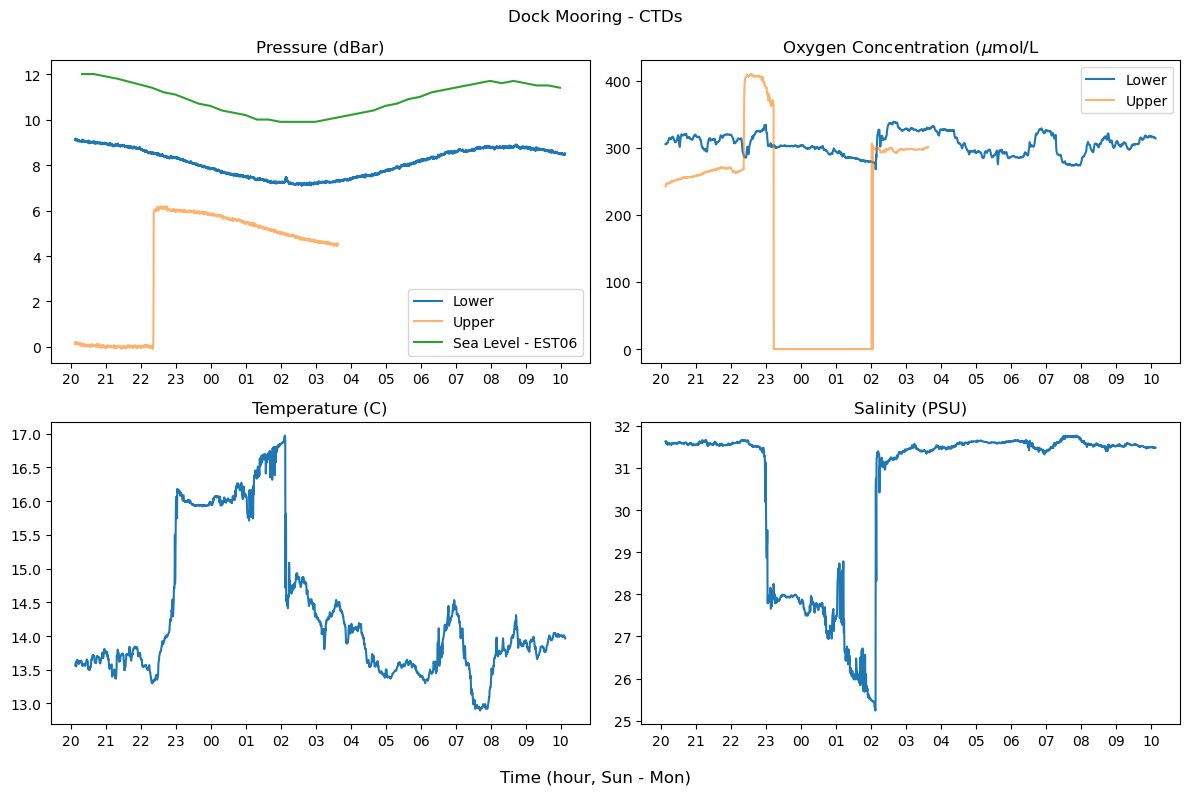

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

x1 = ctd1['dts']
x2 = ctd2['dts']
st = 10

axs[0, 0].plot(x1[st:], ctd1['pres'][st:], label='Lower')
axs[0, 0].plot(x2[st:], ctd2['pres'][st:], label='Upper', alpha=0.6)
axs[0, 0].plot(tides_ts, tides_level, label='Sea Level - EST06')
axs[0, 0].legend()
axs[0, 0].set_title("Pressure (dBar)")

axs[0, 1].plot(x1[st:], ctd1['cal_oxys'][st:], label='Lower')
axs[0, 1].plot(x2[st:], ctd2['oxys'][st:], label='Upper', alpha=0.6)
axs[0, 1].legend()
axs[0, 1].set_title("Oxygen Concentration ($\mu$mol/L")

axs[1, 0].plot(x1[st:], ctd1['temps'][st:])
axs[1, 0].set_title("Temperature (C)")

axs[1, 1].plot(x1[st:], ctd1['sals'][st:])
axs[1, 1].set_title("Salinity (PSU)")

for ax_r in axs:
    for ax_c in ax_r:
        mins = MinuteLocator(interval=60)
        dateFmt = DateFormatter('%H')
        ax_c.xaxis.set_major_locator(mins)
        ax_c.xaxis.set_major_formatter(dateFmt)


fig.supxlabel("Time (hour, Sun - Mon)")
fig.suptitle("Dock Mooring - CTDs")
fig.tight_layout()

plt.savefig('figs/mooring_both.png')
plt.show()

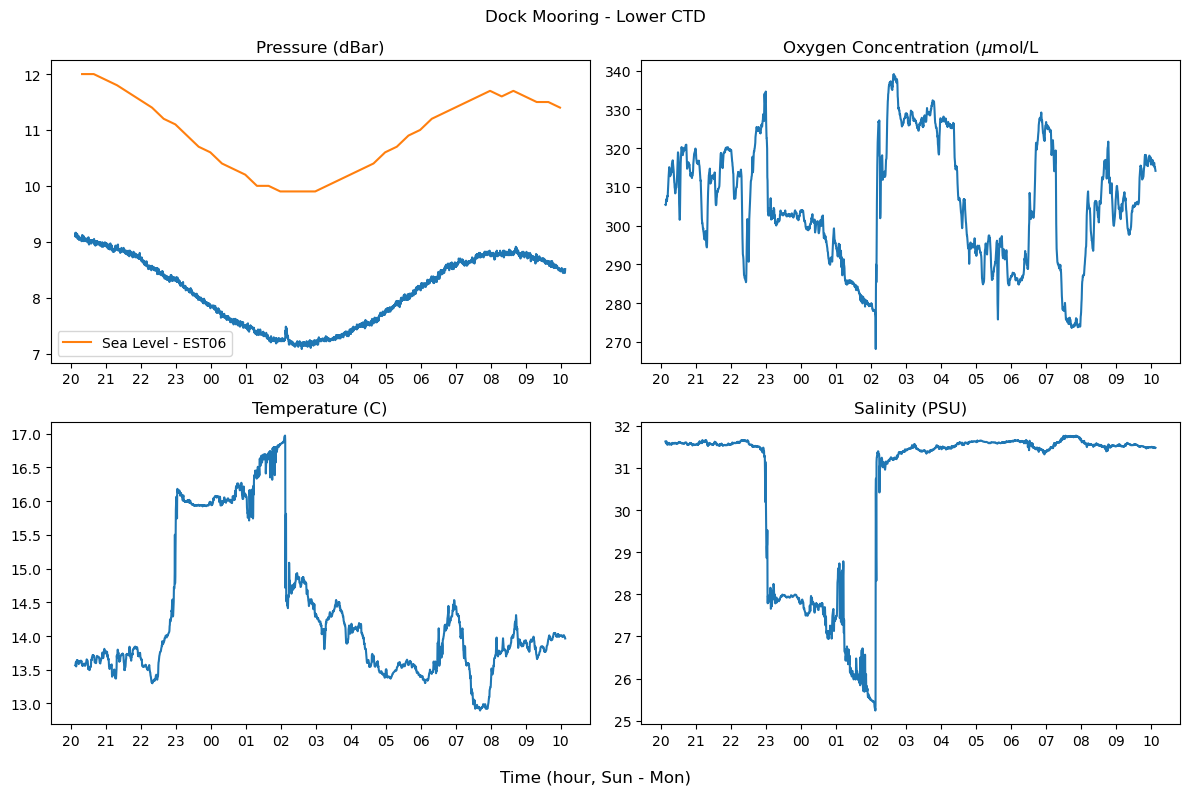

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

x1 = ctd1['dts']
st = 10

axs[0, 0].plot(x1[st:], ctd1['pres'][st:])
axs[0, 0].plot(tides_ts, tides_level, label='Sea Level - EST06')
axs[0, 0].legend()
axs[0, 0].set_title("Pressure (dBar)")

axs[0, 1].plot(x1[st:], ctd1['cal_oxys'][st:])
axs[0, 1].set_title("Oxygen Concentration ($\mu$mol/L")

axs[1, 0].plot(x1[st:], ctd1['temps'][st:])
axs[1, 0].set_title("Temperature (C)")

axs[1, 1].plot(x1[st:], ctd1['sals'][st:])
axs[1, 1].set_title("Salinity (PSU)")

for ax_r in axs:
    for ax_c in ax_r:
        mins = MinuteLocator(interval=60)
        dateFmt = DateFormatter('%H')
        ax_c.xaxis.set_major_locator(mins)
        ax_c.xaxis.set_major_formatter(dateFmt)


fig.supxlabel("Time (hour, Sun - Mon)")
fig.suptitle("Dock Mooring - Lower CTD")
fig.tight_layout()

plt.savefig('figs/mooring_lower.png')
plt.show()